## Problem 1 - Perceptron

### Answer 1.1

Import `numpy` and `matplotlib`

In [62]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

%matplotlib inline

Define needed functions related to generating and plotting 2D data points

In [63]:
# Function to generate $n$ points of $(x1, x2)$, with range: $low \leq x1 \leq x2 \leq high$
def generate_2D_points(low, high, n_points, seed=None):
    if seed != None:
        np.random.seed(seed)
    
    x1_arr = np.random.uniform(low, high, n_points)
    x2_arr = np.random.uniform(low, high, n_points)

    class_1_data, class_2_data = ([], [])

    for x1, x2 in zip(x1_arr, x2_arr):
        if x1 > x2:
            class_1_data.append((x1, x2))
        else:
            class_2_data.append((x1, x2))

    class_1_data, class_2_data = (np.array(class_1_data), np.array(class_2_data))
    
    return class_1_data, class_2_data

# Function to plot 2D points, color coded based on class (two classes)
def plot_2D_points(class_1_data, class_2_data, class_3_data=[]):
    plt.plot(class_1_data[:, 0], class_1_data[:, 1], 'o', color='green', label='Class 1')

    plt.plot(class_2_data[:, 0], class_2_data[:, 1], 'o', color='blue', label='Class 2')
    
    if len(class_3_data) > 0:
        plt.plot(class_3_data[:, 0], class_3_data[:, 1], 'o', color='red', label='Removed Points')
        
    ax = plt.gca()
    ax.set(xlabel = 'x1', ylabel = 'x2')

    plt.title('2D Scatter Plot for points (x1, x2) in Class 1 (Green) and Class 2 (Blue)')
    plt.legend()
    plt.show()

Generate $20$ points in the `unit square of positive quadrant`, i.e. `Quadrant I` with range: $0 \leq x1 \leq x2 \leq 1$. This is for the training data.

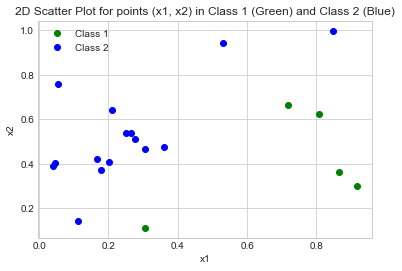

In [64]:
class_1_train_data, class_2_train_data = generate_2D_points(0, 1, 20, 15)

plot_2D_points(class_1_train_data, class_2_train_data)

Generate $1000$ points in the `unit square of positive quadrant`, i.e. `Quadrant I` with range: $0 \leq x1 \leq x2 \leq 1$. This is for the test data.

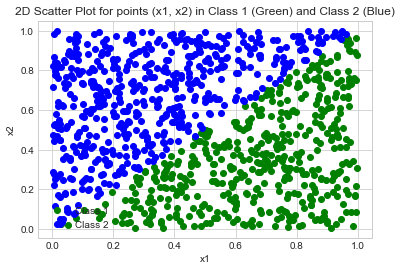

In [65]:
class_1_test_data, class_2_test_data = generate_2D_points(0, 1, 1000, 15)

plot_2D_points(class_1_test_data, class_2_test_data)

Build X and y for train and test, check if the shape matches.


In [66]:
X_train = np.hstack([class_1_train_data.T, class_2_train_data.T])
X_test = np.hstack([class_1_test_data.T, class_2_test_data.T])

assert X_train.shape == (2, 20)
assert X_test.shape == (2, 1000)

y_train = np.concatenate((np.full(len(class_1_train_data), float(1.0)), np.full(len(class_2_train_data), float(-1.0))), axis=None)
y_test = np.concatenate((np.full(len(class_1_test_data), float(1.0)), np.full(len(class_2_test_data), float(-1.0))), axis=None)

assert y_train.shape == (20,)
assert y_test.shape == (1000,)


Shuffle the data first so later in each minibatch, the Perceptron sees data from both labels

In [67]:
def shuffle(X, y):
    idxes = np.arange(X.shape[1])
    np.random.shuffle(idxes)
    
    return np.array([X[0][idxes], X[1][idxes]]), y[idxes]

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

Define Perceptron related functions

In [68]:
# Return label given output using sign function
# x should be an NDARRAY, not a scalar
def sign(x):
    return np.array([1.0 if val >= 0 else -1.0 for val in x])

# Predict label using sign activation
def predict(W, X):
    return sign(np.dot(W.T, X))

# Init weights randomly using normal distribution
def init_weights(w_ranges, seed=None):
    if seed != None:
        np.random.seed(seed)
        
    w1 = np.random.uniform(w_ranges[0][0], w_ranges[0][1], size=None)
    w2 = np.random.uniform(w_ranges[1][0], w_ranges[1][1], size=None)
    
    return np.array([w1, w2])

# X should be in the shape of (n_features, n_data)
# y should be in the shape of (n_data,)
# Function to compute loss
def forward_propagate(W, X, y, algo):
    n_data = X.shape[1]
    
    # a equals 0 for Perceptron Criterion and 1 for Hinge-Loss
    if algo == 'Perceptron criterion':
        a = np.zeros(n_data)
    
    elif algo == 'Hinge loss':
        a = np.full(n_data, 1)
        
    else:
        print('Invalid algorithm')
        assert False
    
    outputs = np.dot(W.T, X)
    assert outputs.shape == (n_data,)
    
    # IMPORTANT: Do ELEMENT-WISE multiplication for y against the output
    diffs = a - np.multiply(y, outputs)
    assert diffs.shape == (n_data,)
    
    losses = np.maximum(np.zeros(n_data), diffs)
    assert losses.shape == (n_data,)
    
    # IMPORTANT: Don't forget to divide the losses 
    # by the total number of data so that the updates
    # are not EXTREME
    losses = np.divide(losses, n_data)
    assert losses.shape == (n_data,)

    return outputs, losses

# X should be in the shape of (n_features, n_data)
# y should be in the shape of (n_data,)
# Function to update weights
def back_propagate(W, X, y, outputs, losses, learning_rate):
    y_preds = sign(outputs)
    assert y_preds.shape == (X.shape[1],)
    
    diff = np.subtract(y, y_preds)
    assert diff.shape == (X.shape[1],)
    
    # Update only when loss > 0
    for i, loss in enumerate(losses):
        if loss > 0.0:
            # IMPORTANT: Slice the second axis
            curr_X = X[:, i]
            assert curr_X.shape == (X.shape[0],)
            
            update_values = np.multiply(learning_rate, np.multiply(curr_X, diff[i]))
            assert update_values.shape == (X.shape[0],)

            W = np.add(W, update_values)
            assert W.shape == (X.shape[0],)
    
    return W

Training related functions

In [69]:
# Train loop, stops when error is zero or when max_iter is reached
def train(X, y, algo, learning_rate, max_iter, w_ranges, seed, debug):
    W = init_weights(w_ranges, seed)
    
    print('Initial Weights:')
    print('w1: {:.2f}, w2: {:.2f}'.format(W[0], W[1]))
    print('-----------------------')

    i = 0
    
    while True:
        outputs, losses = forward_propagate(W, X_train, y_train, algo)
        W = back_propagate(W, X_train, y_train, outputs, losses, learning_rate)
        
        avg_losses = np.mean(losses)
        misc = compute_performance(W, X_train, y_train, 'misc')
        
        if algo == 'Perceptron criterion':
            if misc == 0:
                break
                
        elif algo == 'Hinge loss':
            if avg_losses == 0.0:
                break
                
        else:
            print('Invalid algorithm')
            assert False
        
        i = i + 1
        
        if i < max_iter:
            if debug[0]:
                if i % debug[1] == 0:
                    print('Iteration: {}'.format(i))
                    print('Number of misclassified examples: {}'.format(misc))
                    print('w1: {:.2f}, w2: {:.2f}'.format(W[0], W[1]))
                    print('-----------------------')
        
        else:
            break
    
    print('{} stops at iteration: {}'.format(algo, i))
    print('Number of misclassified examples: {}'.format(misc))
    print('w1: {:.2f}, w2: {:.2f}'.format(W[0], W[1]))
    print('-----------------------')
    
    return W
   
# Call predict to get labels and then compute test accuracy
def compute_performance(W, X, y, ret_type):
    y_preds = predict(W, X)
    
    verdict = [1 if val1 == val2 else 0 for val1, val2 in zip(y_preds, y)]
    
    if ret_type == 'misc':
        return len(y) - np.sum(verdict)
    elif ret_type == 'acc':
        return np.sum(verdict) / len(y)

Train for Perceptron criterion

In [18]:
algo = 'Perceptron criterion'
learning_rate = 0.1
n_iters = 100 # Stop when loss equals zero or reach n_iters
debug = (False, None)

# Initial value range for (w1, w2), uniform random from -0.1 to 0.1
w_ranges = ((-0.1, 0.1), (-0.1, 0.1)) 
seed = 8

W_pc = train(X_train, y_train, algo, learning_rate, n_iters, w_ranges, seed, debug)
test_acc = compute_performance(W_pc, X_test, y_test, 'acc')

print('Test accuracy using Perceptron criterion is: {}'.format(test_acc))
print('-----------------------')

Initial Weights:
w1: 0.07, w2: 0.09
-----------------------
Perceptron criterion stops at iteration: 2
Number of misclassified examples: 0
w1: 0.75, w2: -0.68
-----------------------
Test accuracy using Perceptron criterion is: 0.952
-----------------------


### Answer 1.2

Train for Hinge losss

In [10]:
algo = 'Hinge loss'
learning_rate = 0.1
n_iters = 100 # Stop when loss equals zero or reach n_iters
debug = (False, None)

# Initial value range for (w1, w2), uniform random from -0.1 to 0.1
w_ranges = ((-0.1, 0.1), (-0.1, 0.1))
seed = 8

W_hl = train(X_train, y_train, algo, learning_rate, n_iters, w_ranges, seed, debug)
test_acc = compute_performance(W_hl, X_test, y_test, 'acc')

print('Test accuracy using Hinge loss is: {}'.format(test_acc))
print('-----------------------')

Initial Weights:
w1: 0.07, w2: 0.09
-----------------------
Hinge loss stops at iteration: 100
Number of misclassified examples: 0
w1: 1.77, w2: -1.85
-----------------------
Test accuracy using Hinge loss is: 0.974
-----------------------


### Answer 1.3

Question:

In which case do you obtain better accuracy and why?

Answer:

I obtained better test accuracy using Hinge loss (0.974) compared to Perceptron criterion (0.952). 

We know that Perceptron criterion only updates the weights when there is a discrepancy between the predicted sign, i.e. $\hat{y} = sign(\bar{W}.\bar{X})$, and the true sign, i.e. $y$. Thus, the decision boundary produces by the Perceptron doesn't really maximize the margin between the two classes: $y=-1$ and $y=1$.

Meanwhile, Hinge loss also updates the weights when there is a discrepancy between the predicted output, i.e. $\bar{W}.\bar{X}$, and the actual output, denoted by $1 - y(\bar{W}.\bar{X})$. Thus, it maximizes the margin between the two classes and is more robust to the actual data/test set than Perceptron criterion.

### Answer 1.4

Question:

In which case do you think that the classification of the same 1000 test instances will not change significantly by using a different set of 20 training points? (2)

Answer:

In Hinge loss case, with the similar reasoning as part 1.3. We know that Hinge loss always maximizes the margin between the two classes. 

Since Hinge loss always maximize the margin, the resulting decision boundary will remain similar. Meanwhile, in the Perceptron case, the resulting decision boundary very much depends on the location of the training data for each class. 

Take a look again at the training data.

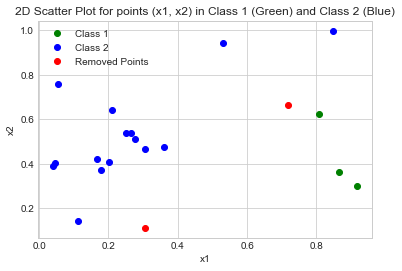

In [70]:
plot_2D_points(class_1_train_data[[1, 3, 4]], class_2_train_data, class_1_train_data[[0, 2]])

Suppose that we remove the two points near the true decision boundary $x_1 - x_2 = 0$ from Class 1, denoted by the red dots. In that case, we can infer that the Perceptron might have a decision boundary that is close towards the green region, say something like $2x_1 - 3x_2 = 0$. This decision boundary is not close to the true decision boundary of $x_1 - x_2 = 0$. Thus, Perceptron criterion classification will likely to change significantly given different training data.

## Problem 2 - Weight Initialization, Dead Neurons, Leaky ReLU

### Answer 2.1

Check that we are using `Tensorflow 2.3`, otherwise some functions like `tf.keras.initializers.HeNormal` are not available

In [12]:
!pip show tensorflow

Name: tensorflow
Version: 2.3.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages
Requires: astunparse, gast, numpy, wheel, tensorflow-estimator, protobuf, keras-preprocessing, opt-einsum, grpcio, wrapt, google-pasta, absl-py, h5py, tensorboard, six, termcolor
Required-by: 


Codebase from https://github.com/Intoli/intoli-article-materials/tree/master/articles/neural-network-initialization

In [71]:
import pandas as pd

import seaborn as sns
from matplotlib import rcParamsDefault

import tensorflow.keras
from tensorflow.keras import initializers

from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras import backend as K

In [72]:
def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.
    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.
    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax


def create_mlp_model(
    n_hidden_layers,
    dim_layer,
    input_shape,
    n_classes,
    kernel_initializer,
    bias_initializer,
    activation,
):
    """Create Multi-Layer Perceptron with given parameters."""
    model = Sequential()
    model.add(Dense(dim_layer, input_shape=input_shape, kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(Dense(dim_layer, activation=activation, kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def compile_model(model):
    model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
                  optimizer=tensorflow.keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
    return model


def get_activations(model, x, mode=0.0):
    """Extract activations with given model and input vector x."""
    outputs = [layer.output for layer in model.layers]
    activations = K.function([model.input], outputs)
    output_elts = activations([x, mode])
    return output_elts

Divide the main routine from the original source code into some functions below, for reusability and readability

In [73]:
def generate_mnist_data(flatten=False, newaxis=False):
    # Load and prepare MNIST dataset.
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    data_dim = 784
    n_train = len(X_train)
    n_test = len(X_test)
    n_classes = len(np.unique(y_test))
    
    if flatten:
        X_train = X_train.reshape(n_train, data_dim).astype('float32')[:n_train]
        X_test = X_test.reshape(n_test, data_dim).astype('float32')[:n_test]
        
        if newaxis:
            X_train = X_train[:, :, np.newaxis]
            X_test = X_test[:, :, np.newaxis]
    else:
        X_train = X_train.astype('float32')[:n_train]
        X_test = X_test.astype('float32')[:n_test]
        
        if newaxis:
            X_train = X_train[:, :, :, np.newaxis]
            X_test = X_test[:, :, :, np.newaxis]
        
    X_train /= 255.0
    X_test /= 255.0

    y_train = tensorflow.keras.utils.to_categorical(y_train, n_classes)
    y_test = tensorflow.keras.utils.to_categorical(y_test, n_classes)

    return X_train, y_train, X_test, y_test, n_classes, data_dim

def train_model(params, X):
    activation_data = []
    
    if params['kernel_init'] == 'random_normal':
        print('Using Random Normal')
        kernel_init = initializers.RandomNormal(mean=0.0, stddev=params['stddev'], seed=params['seed'])
    elif params['kernel_init'] == 'glorot_normal':
        print('Using Glorot Normal')
        kernel_init = initializers.GlorotNormal(seed=params['seed'])
    elif params['kernel_init'] == 'he_normal':
        print('Using He Normal')
        kernel_init = initializers.HeNormal(seed=params['seed'])
    else:
        print('Invalid initializer')
        assert False

    model = create_mlp_model(
        params['n_hidden_layers'],
        params['dim_layer'],
        (params['data_dim'],),
        params['n_classes'],
        kernel_init,
        params['bias_init'],
        params['activation']
    )
    
    compile_model(model)
    
    output_elts = get_activations(model, X)
    
    n_layers = len(model.layers)
    
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                activation_data.append([i, stddev, out_i])
                
    return activation_data   

def plot_activations_random_normal(df, sigmas, activation):
    # Plot previously saved activations from the 5 hidden layers
    # using different initialization schemes.
    fig = plt.figure(figsize=(12, 9))

    axes = grid_axes_it(len(sigmas), 1, fig=fig)

    for i, sig in enumerate(sigmas):
        ax = next(axes)
        ddf = df[df['Standard Deviation'] == sig]
        sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

        ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {:.2f})$ using {} activation function in hidden layers'.format(sig, activation), fontsize=13)

        ax.set_xlabel("Hidden Layer")

        if i == len(sigmas) // 2: 
            ax.set_ylabel("Neuron Activations")

        if i != len(sigmas) - 1:
            ax.set_xticklabels(())

    plt.tight_layout()
    plt.show()
    
def plot_activations_glorot_and_he_normal(df, init, activation):
    # Plot previously saved activations from the 5 hidden layers
    # using different initialization schemes.
    fig = plt.figure(figsize=(15, 12))

    axes = grid_axes_it(1, 1, fig=fig)
    ax = next(axes)
    
    sns.violinplot(x='Hidden Layer', y='Output', data=df, ax=ax, scale='count', inner=None)

    ax.set_title('Weights Drawn from {} Uniform using {} activation function in hidden layers'.format(init, activation), fontsize=13)

    ax.set_xlabel("Hidden Layer")
    ax.set_ylabel("Neuron Activations")
    ax.set_xticklabels(())

    plt.tight_layout()
    plt.show()


Vanishing Gradients Phenomenon using Random Normal Initialization for Tanh and Sigmoid Activation Function

Tanh Hidden Layer Neuron Activation Plots
-------------------
Using Random Normal
Using Random Normal
Using Random Normal


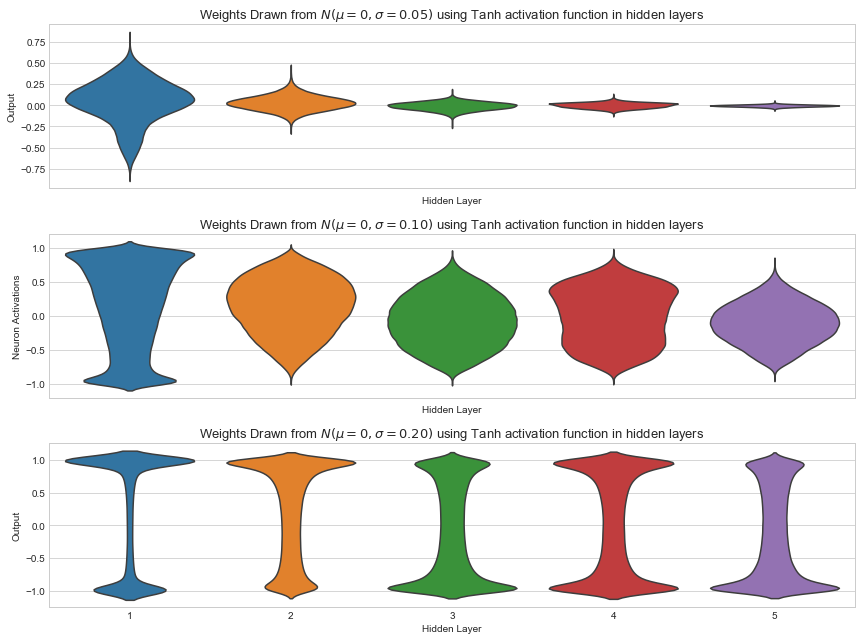

Sigmoid Hidden Layer Neuron Activation Plots
-------------------
Using Random Normal


In [ ]:
# Generate train and test data from MNIST
X_train, y_train, X_test, y_test, n_classes, data_dim = generate_mnist_data(flatten=True, newaxis=False)

# MLP Params in relation to the dataset
params = {
    'n_hidden_layers': 5,
    'dim_layer': 100,
    'data_dim': data_dim,
    'n_classes': n_classes,
    'kernel_init': 'random_normal',
    'bias_init': 'zeros',
    'seed': 10
}

# Run the data through a few MLP models and save the activations from
# each layer into a Pandas DataFrame.
activation_data = []
activations = ['Tanh', 'Sigmoid']
sigmas = [0.05, 0.1, 0.2]

for activation in activations:
    print(activation + ' Hidden Layer Neuron Activation Plots')
    print('-------------------')
    
    params['activation'] = activation.lower()
    
    for stddev in sigmas:
        params['stddev'] = stddev
        
        for activation_datum in train_model(params, X_train):
            activation_data.append(activation_datum)

    df = pd.DataFrame(activation_data, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

    plot_activations_random_normal(df, sigmas, activation)

We can see that for `tanh`:

1. $\sigma=0.05$ results in vanishing gradients, i.e. the neuron activation distribution gears towards zero.
2. $\sigma=0.1$ results in stable gradients, i.e. the neuron activation distribution remains somewhat the same. It is bubbly in the middle although the shape differs between layers.
3. $\sigma=0.2$ results in exploding gradients as more and more big activation values (close to $-1.0$) arises, although we actually need to confirm this by performing more iterations.

We can see that for `sigmoid`:

1. $\sigma=0.05$ results in vanishing gradients, i.e. the neuron activation distribution gears towards zero, although there are still a big portion of the activations (30-40%) with value bigger than $0.5$.
2. $\sigma=0.1$ results in stable gradients, i.e. the neuron activation distribution remains 80-90% the same between layers, except for Layer 1.
3. $\sigma=0.2$ results in exploding gradients as more and more big activation values ($>0$) arise especially in layer 4 and 5.

Fixing Vanishing Gradients Phenomenon using Glorot Uniform Initialization for Tanh and Sigmoid Activation Function

In [ ]:
# Update 'kernel_init', i.e. weight initializer, in MLP Params
params['kernel_init'] = 'glorot_normal' 

# Empty activation data
activation_data = []

# Add ReLU activation function
activations.append('ReLU')

for activation in activations:
    print(activation + ' Hidden Layer Neuron Activation Plots')
    print('-------------------')
    
    params['activation'] = activation.lower()
        
    for activation_datum in train_model(params, X_train):
        activation_data.append(activation_datum)

    df = pd.DataFrame(activation_data, columns=['Hidden Layer', 'Standard Deviation', 'Output'])
    df.drop(['Standard Deviation'], axis=1)

    plot_activations_glorot_and_he_normal(df, 'Glorot Normal', activation)

We can see that by using `Xavier` initialization, the neuron activation value distribution retains its shape between layers, except Layer 1. This applies for all activation functions: `tanh`, `sigmoid` and `ReLU`. `Xavier` clearly helps in dealing with the vanishing/exploding gradients problem.

Finally, we're using He initializers with ReLU activation function in hidden layers

In [ ]:
# Update 'kernel_init', i.e. weight initializer, in MLP Params
params['kernel_init'] = 'he_normal' 

# Empty activation data
activation_data = []

# Only use ReLU
activations = ['ReLU']

for activation in activations:
    print(activation + ' Hidden Layer Neuron Activation Plots')
    print('-------------------')
    
    params['activation'] = activation.lower()
        
    for activation_datum in train_model(params, X_train):
        activation_data.append(activation_datum)

    df = pd.DataFrame(activation_data, columns=['Hidden Layer', 'Standard Deviation', 'Output'])
    df.drop(['Standard Deviation'], axis=1)

    plot_activations_glorot_and_he_normal(df, 'He Normal', activation)

`He` initializers when using `ReLU` activation function, just like `Xavier`, retains the shape between layers, i.e. the neuron activation value distribution doesn't change between layers. However, what makes `He` better from `Xavier` is that it keeps most of the activation values low, close to zero (somewhere around $0.15-0.2$), so that the gradients definitely won't explode no matter what.

### Answer 2.2

Generate dataset related functions

In [22]:
import time

from tensorflow.keras.layers import ReLU, LeakyReLU

I use `He Normal` initialization, just like the paper, and I pick $f_2(x) = xsin(5x)$.

In [23]:
# Use f(x) = xsin(5x)
def f_x(x):
    return np.multiply(x, np.sin(np.multiply(x, 5.0)))

def generate_dataset(n_data):
    X = np.random.uniform(-1.0 * np.sqrt(7), np.sqrt(7), n_data)
    assert X.shape == (n_data,)

    y = f_x(X)
    assert y.shape == (n_data,)
    
    return X, y

def train_test_split(X, y, train_ratio):
    n_data = len(X)
    assert n_data == len(y)
    
    idx_split = int(train_ratio * n_data)
    
    return X[:idx_split], y[:idx_split], X[idx_split:], y[idx_split:]

Enable parallel training, each model training will now take only 0.1 fraction of the GPU

In [24]:
# import tensorflow as tf
# from tensorflow.compat.v1.keras.backend import set_session

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.1 # set 0.3 to what you want
# set_session(tf.Session(config=config))

Define network and its training

In [25]:
def build_relu_model(params):
    # Create the model as sequential
    model = Sequential()

    # First hidden layer
    model.add(Dense(
        params['n_hidden_units'], 
        input_shape=(params['feature_vector_length'],), 
        activation=params['activation'],
        kernel_initializer=params['kernel_init'],
        bias_initializer=params['bias_init']
    ))

    # The rest of the hidden layers
    for i in range(params['n_hidden_layers']-1):
        model.add(Dense(params['n_hidden_units'], activation=params['activation']))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile, use MAE loss, Adam optimizer
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=params['metrics'])
        
    return model

def train_dying_relu(params):
    collapse_count = 0
    
    if params['timed']:
        start = time.time()
    
    for i in range(0, params['n_experiments']):
        X, y = generate_dataset(params['n_data'])
        
        X_train, y_train, X_test, y_test = train_test_split(X, y, 0.8)
        
        # Make sure weights are different every time we do the independent experiment
        model = build_relu_model(params)
        
        # Train using minibatches
        model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=params['verbose'])
        
        # Check if collapsed
        if is_collapsed(model, X_test, params['threshold']):
            collapse_count += 1
        
        if (i+1) % 100 == 0:
            print('Experiment number: {}'.format(i+1))
            
            if params['timed']:
                end = time.time()

                print('Elapsed time: {}'.format(end - start))
                
                start = time.time()
        
    return collapse_count / params['n_experiments'] * 100

# Define functions to check if network collapses
def is_collapsed(network, X_test, threshold):
    y_preds = network.predict(X_test).flatten()
    
    if np.var(y_preds) <= threshold:
        return True
    
    return False

In [23]:
# Training configs
params = {
    'feature_vector_length': 1,
    'n_hidden_layers': 10,
    'n_hidden_units': 2,
    'batch_size': 64,
    'activation': ReLU(),
    'kernel_init': initializers.HeNormal(seed=82),
    'bias_init': initializers.Zeros(),
    'loss': 'mean_absolute_error',
    'optimizer': 'adam',
    'metrics': 'mean_squared_error',
    'epochs': 10,
    'verbose': 0,
    'timed': True,
    'n_data': 3000,
    'n_experiments': 1000,
    'threshold': 1e-4 # To determine if network collapses
}

collapse_percentage = train_dying_relu(params)

print('Collapse percentage for ReLU is: {:.2f}%'.format(collapse_percentage))

Experiment number: 100
Elapsed time: 105.23079204559326
Experiment number: 200
Elapsed time: 101.63839793205261
Experiment number: 300
Elapsed time: 98.34980010986328
Experiment number: 400
Elapsed time: 100.77714371681213
Experiment number: 500
Elapsed time: 103.74595093727112
Experiment number: 600
Elapsed time: 104.47440195083618
Experiment number: 700
Elapsed time: 101.71140384674072
Experiment number: 800
Elapsed time: 109.95154523849487
Experiment number: 900
Elapsed time: 117.58582472801208
Experiment number: 1000
Elapsed time: 121.34460592269897
Collapse percentage for ReLU is: 95.30%


So, there are $953$ networks (out of $1000$) that collapse. The fraction is over $90$% indeed but not really close to what was reported in Lu et al. Using He Normal initialization and $f_2(x) = xsin(5x)$, the authors get $91.9$% meanwhile I got $95.3$%.

### Answer 2.3

Just change the `activation` to `LeakyReLU` with `alpha=0.01`

In [59]:
# Changes only the activation
params['activation'] = LeakyReLU(alpha=0.01)

leaky_collapse_percentage = train_dying_relu(params)

print('Collapse percentage for Leaky ReLU with $\{alpha} = 0.01$ is: {:.2f}%'.format(leaky_collapse_percentage))

KeyError: 'timed'

We can see that the collapse percentage is now reduced to $76.20$% from $95.30$%. So, Leaky ReLU does help in preventing dying neurons even though in this case it is not hugely significant (+- $20$% improvement).

## Problem 3 - Batch Normalization, Dropout, MNIST

### Answer 3.1

Question:

Explain the terms co-adaptation and internal covariance-shift. Use examples if needed. You may need to refer to two papers mentioned below to answer this question.

Answer:

1. Co-Adaptation: In deep learning/neural networks, Co-Adaptation happens when different hidden units have similar behavior so that they might cancel each other out [1]. It is not good because it is computationally inefficient and we desire different hidden units to function differently, i.e. to detect independent features. For example, suppose we have two hidden units, each have four incoming weights from the previous units/nodes, denoted by $[w_{11}, ..., w_{14}]$ and $[w_{21}, ..., w_{24}]$ below: $$w_{1}=[−0.82,1.23,−2.34,0.82]$$ $$w_2=[−0.82,−1.20,2.29,0.82]$$ We can see that $w_{12}$ cancels $w_{22}$ and $w_{13}$ cancels $w_{23}$ since their absolute values are similar but they are of different signs. In this case, we actually only need 2 previous nodes to approximate the function, but we have 4 nodes instead. This is indesirable because it means those four weights have high coupling with each other. Not only inefficient, but in the case of one the weights is rendered invalid (e.g. the server crashes and loses its value), then the other couldn't take over the job since they represent more or less the same feature and the network fails, i.e. producing very different output. Dropout mechanism solves this problem.

2. Internal Covariance-Shift: In deep learning/neural networks, Internal Covariance-Shift is defined as the change in the distribution of network activations due to the change in network parameters/weights during training [2]. We know that the output of the first layer is fed into the second layer and so on. Thus, when the weights are updated, the distribution of inputs to subsequent layers will follow suit. Since hidden layers will try to cope with the new distribution every iteration, then the training will be slower, particularly when the statistical distribution of the input to the networks is drastically different from the previous one. For example, consider MLP that is trained with MNIST data in grayscale images. If we now try to apply this MLP to colored handwritten digits, then it will not perform. Both are handwritten digits but obviously with different statistics (mean and variance). To sum up, if a neural network learns some mapping $X \rightarrow Y$ and the distribution of $X$ changes, then we might need to retrain the network by aligning the distribution of $X$ with the distribution of $Y$. Batch Normalization solves this problem.

Reference:

1. https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf
2. https://arxiv.org/pdf/1502.03167.pdf

### Answer 3.2

Define Le-Net 5, reference: https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/

In [26]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam

In [27]:
def build_lenet_5(batch_norm_params, dropout_params, learning_rate=0.01):
    model = Sequential()

    # Add the first convolution layer
    model.add(Conv2D(
        filters = 20,
        kernel_size = (5, 5),
        padding = "same",
        input_shape = (28, 28, 1)))
    
    if batch_norm_params['prev_to_act'] and batch_norm_params['input_layer']:
        if batch_norm_params['input_norm_type'] == 'batch_norm':
            model.add(BatchNormalization())
        
    if dropout_params['prev_to_act'] and dropout_params['input_layer']:
        model.add(Dropout(dropout_params['input_layer_rate']))

    # Add a ReLU activation function
    model.add(Activation(
        activation = "relu"))
    
    if not batch_norm_params['prev_to_act'] and batch_norm_params['input_layer']:
        if batch_norm_params['input_norm_type'] == 'batch_norm':
            model.add(BatchNormalization())
        
    if not dropout_params['prev_to_act'] and dropout_params['input_layer']:
        model.add(Dropout(dropout_params['input_layer_rate']))

    # Add a pooling layer
    model.add(MaxPooling2D(
        pool_size = (2, 2),
        strides =  (2, 2)))

    # Add the second convolution layer
    model.add(Conv2D(
        filters = 50,
        kernel_size = (5, 5),
        padding = "same"))
    
    if batch_norm_params['prev_to_act'] and batch_norm_params['conv_layers']:
        model.add(BatchNormalization())
        
    if dropout_params['prev_to_act'] and dropout_params['conv_layers']:
        model.add(Dropout(dropout_params['conv_layers_rate']))

    # Add a ReLU activation function
    model.add(Activation(
        activation = "relu"))
    
    if not batch_norm_params['prev_to_act'] and batch_norm_params['conv_layers']:
        model.add(BatchNormalization())
        
    if not dropout_params['prev_to_act'] and dropout_params['conv_layers']:
        model.add(Dropout(dropout_params['conv_layers_rate']))

    # Add a second pooling layer
    model.add(MaxPooling2D(
        pool_size = (2, 2),
        strides = (2, 2)))

    # Flatten the network
    model.add(Flatten())

    # Add a fully-connected hidden layer
    model.add(Dense(500))
    
    if batch_norm_params['prev_to_act'] and batch_norm_params['hidden_layers']:
        model.add(BatchNormalization())
        
    if dropout_params['prev_to_act'] and dropout_params['hidden_layers']:
        model.add(Dropout(dropout_params['hidden_layers_rate']))

    # Add a ReLU activation function
    model.add(Activation(
        activation = "relu"))
    
    if not batch_norm_params['prev_to_act'] and batch_norm['hidden_layers']:
        model.add(BatchNormalization())
        
    if not dropout_params['prev_to_act'] and dropout_params['hidden_layers']:
        model.add(Dropout(dropout_params['hidden_layers_rate']))

    # Add a fully-connected output layer
    model.add(Dense(10))

    # Add a softmax activation function
    model.add(Activation("softmax"))

    # Compile the network
    if 'optimizer' in params:
        opt = params['optimizer']
    else:
        opt = SGD(lr=learning_rate)
        
    model.compile(
        loss = "categorical_crossentropy", 
        optimizer = opt,
        metrics = ["accuracy"])
    
    return model

def train_le_net_5(X_train, y_train, params):  
    if batch_norm_params['input_layer']:
        if batch_norm_params['input_norm_type'] == 'standard_norm':
            layer = preprocessing.Normalization()

            layer.adapt(X_train)

            X_train = layer(X_train)
    
    if 'learning_rate' in params:
        model = build_lenet_5(params['batch_norm_params'], params['dropout_params'], params['learning_rate'])
    else:
        model = build_lenet_5(params['batch_norm_params'], params['dropout_params'])
    
    if 'train_on_batch' in params:
        if params['train_on_batch']:
            history = model.train_on_batch(b_X_train, b_y_train)
            
    if 'validation_data' in params:
        history = model.fit(X_train, y_train, validation_data=params['validation_data'], batch_size=params['batch_size'], epochs=params['nb_epoch'], verbose=params['verbose'])
    else:
        history = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=params['nb_epoch'], verbose=params['verbose'])
    
    return model, history

def evaluate_le_net_5(model, X_test, y_test, params):
    (loss, accuracy) = model.evaluate(X_test, y_test, batch_size=params['batch_size'], verbose=params['verbose'])
    
    return accuracy

Generate `MNIST` data, don't `flatten` because we use `CNN`.

In [28]:
X_train, y_train, X_test, y_test, n_classes, data_dim = generate_mnist_data(flatten=False, newaxis=True)

assert X_train.shape == (60000, 28, 28, 1)
assert X_test.shape == (10000, 28, 28, 1)

Use `Standard Normalization` on `Input Layer/Conv1` and `Batch Normalization` on `Conv2` and `Hidden Layer (Dense 500)`

In [26]:
batch_norm_params = {
    'input_layer': True, 
    'input_norm_type': 'standard_norm', # Use standard normalization for input
    'conv_layers': True,
    'hidden_layers' : True,
    'prev_to_act': True # Place batch norm layer before activation
}

# Don't apply Dropout now
dropout_params = {
    'input_layer': False,
    'conv_layers': False,
    'hidden_layers' : False,
    'prev_to_act': True
}

params = {
    'batch_size': 128,
    'nb_epoch': 2,
    'verbose': 1,
    'batch_norm_params': batch_norm_params,
    'dropout_params': dropout_params
}

model, history = train_le_net_5(X_train, y_train, params)
test_acc = evaluate_le_net_5(model, X_test, y_test, params)

print('Test accuracy: {}'.format(test_acc))

Epoch 1/2
469/469 [==============================] - 88s 188ms/step - loss: 0.2361 - accuracy: 0.9422
Epoch 2/2
79/79 [==============================] - 4s 54ms/step - loss: 3.3232 - accuracy: 0.1143
Test accuracy: 0.11429999768733978


There are two Batch Norm layers in this case, one in the second Conv layer (since the first Conv layer use Standard Norm for input and not Batch Norm) and the other one is the Dense layer of size 500. The learned batch norm parameters are the `Gamma`, i.e. learned scaling factor, and `Beta`, i.e. learned offset factor. For simplicity, I only print the first 5 values for each learned parameter. Reference: https://keras.io/api/layers/normalization_layers/batch_normalization/

In [27]:
for layer in model.layers: 
    layer_name = layer.get_config()['name']
    
    if 'batch_norm' in layer_name:
        print('Layer: {}'.format(layer_name))
        print('----------')
        print('Gamma: ')
        print('Actual shape: {}'.format(layer.gamma.shape))
        print('First five values: {}'.format(layer.gamma[0:5]))
        print('----------')
        print('Beta: ')
        print('Actual shape: {}'.format(layer.beta.shape))
        print('First five values: {}'.format(layer.beta[0:5]))
        print('----------')
        print('----------')

Layer: batch_normalization_10
----------
Gamma: 
Actual shape: (50,)
First five values: [0.9874387  0.9971011  1.001202   0.9991122  0.98946935]
----------
Beta: 
Actual shape: (50,)
First five values: [-0.00131256 -0.00069707 -0.00138437 -0.00421708  0.00052952]
----------
----------
Layer: batch_normalization_11
----------
Gamma: 
Actual shape: (500,)
First five values: [1.0018419 1.0029489 1.002037  1.0028445 1.000374 ]
----------
Beta: 
Actual shape: (500,)
First five values: [ 0.00131035  0.00230246  0.00141146  0.0020749  -0.0009133 ]
----------
----------


Below are the train/test acc/loss statistics at the last epoch.

In [28]:
train_acc = history.history['accuracy'][params['nb_epoch']-1]
train_loss = history.history['loss'][params['nb_epoch']-1]

print('Train acc: {:.4f}'.format(train_acc))
print('Test acc: {:.4f}'.format(test_acc))

print('Train loss: {:.4f}'.format(train_loss))

Train acc: 0.9769
Test acc: 0.1143
Train loss: 0.0913


### Answer 3.3

In [29]:
# Now use batch norm for input as well
batch_norm_params['input_norm_type'] = 'batch_norm'

# Reassign batch_norm_params
params['batch_norm_params'] = batch_norm_params

model, history = train_le_net_5(X_train, y_train, params)
test_acc = evaluate_le_net_5(model, X_test, y_test, params)

print('Test accuracy: {}'.format(test_acc))

Epoch 1/2
469/469 [==============================] - 134s 286ms/step - loss: 0.2338 - accuracy: 0.9410
Epoch 2/2
79/79 [==============================] - 6s 82ms/step - loss: 0.0662 - accuracy: 0.9835
Test accuracy: 0.9835000038146973


Violin Plots for Learned Batch Norm Learned Parameters (`Beta` and `Gamma`) for each Layer (`Input/Conv1`, `Conv2` and `Dense 500`)

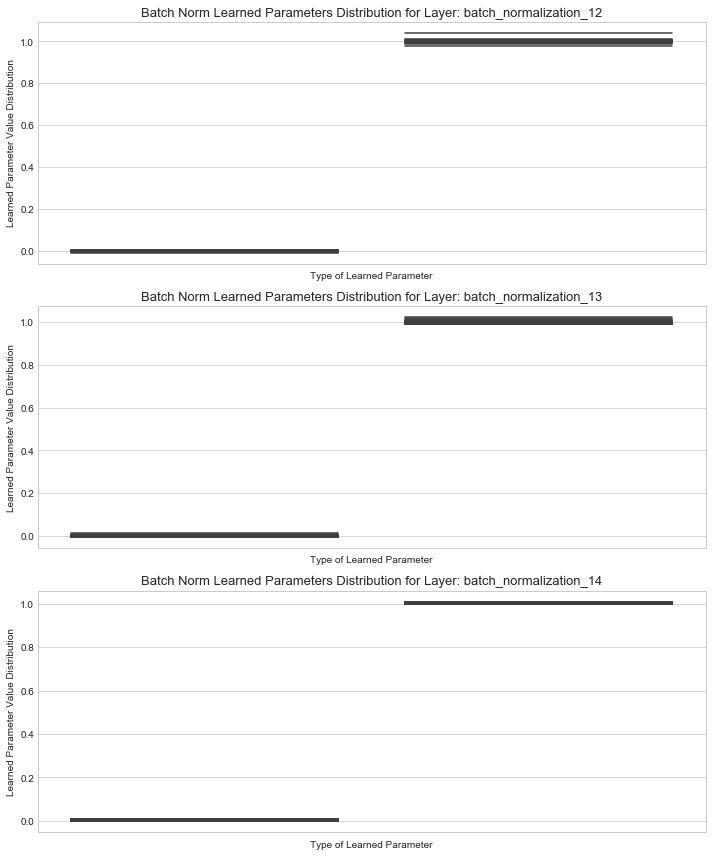

In [30]:
X = ['Beta', 'Gamma']

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(10, 12))

axes = grid_axes_it(3, 1, fig=fig)

for i, layer in enumerate(model.layers): 
    layer_name = layer.get_config()['name']
    
    if 'batch_norm' in layer_name:
        ax = next(axes)
        
        y = [layer.beta.numpy(), layer.gamma.numpy()]
    
        sns.violinplot(x=X, y=y, ax=ax, scale='count', inner=None)

        ax.set_title("Batch Norm Learned Parameters Distribution for Layer: {}".format(layer_name), fontsize=13)
        
        ax.set_xlabel("Type of Learned Parameter")
        ax.set_ylabel("Learned Parameter Value Distribution")

        ax.set_xticklabels(())

plt.tight_layout()
plt.show()

Below are the train/test acc/loss statistics at the last epoch.

In [31]:
train_acc = history.history['accuracy'][params['nb_epoch']-1]
train_loss = history.history['loss'][params['nb_epoch']-1]

print('Train acc: {:.4f}'.format(train_acc))
print('Test acc: {:.4f}'.format(test_acc))

print('Train loss: {:.4f}'.format(train_loss))

Train acc: 0.9773
Test acc: 0.9835
Train loss: 0.0891


We can see that in this case, `Batch Normalization` on Input Layer, compared to `Standard Normalization` in Part 2:

1. Has similar performance on the training data. It has train accuracy of $0.9773$ compared to $0.9769$ from Part 2 and training loss of $0.0891$ compared to $0.0913$ from Part 2

2. Has EXTREMELY BETTER performance on the test set. It has test accuracy of $0.9835$ (even greater than the train set) compared to $0.1143$ from Part 2 which is super low. Test accuracy of $0.1143$ from Part 2 is basically the same as picking class at random, which should yield ~$0.1$ accuracy.

### Answer 3.4

In [32]:
# Now invalidate batch_norm_params
batch_norm_params = {
    'input_layer': False,
    'conv_layers': False,
    'hidden_layers' : False,
    'prev_to_act': True # Place batch norm layer before activation
}

# Apply Dropout now
dropout_params = {
    'input_layer': True,
    'conv_layers': True,
    'hidden_layers' : True,
    'prev_to_act': True,
    'input_layer_rate': 0.2,
    'conv_layers_rate': 0.5,
    'hidden_layers_rate': 0.5
}

# Reassign both batch_norm_params and dropout_params
params['batch_norm_params'] = batch_norm_params
params['dropout_params'] = dropout_params

model, history = train_le_net_5(X_train, y_train, params)
test_acc = evaluate_le_net_5(model, X_test, y_test, params)

print('Test accuracy: {}'.format(test_acc))

Epoch 1/2
469/469 [==============================] - 134s 285ms/step - loss: 0.8524 - accuracy: 0.7267
Epoch 2/2
79/79 [==============================] - 8s 107ms/step - loss: 0.3169 - accuracy: 0.9518
Test accuracy: 0.9517999887466431


Compared to test accuracy in Part 2, this test accuracy is certainly far better just like the previous case in Part 3. But, compared to Part 3, it is slightly lower ($0.9518$ vs $0.9835$). Thus, `Dropout` in this case is not better than `Batch Normalization`. 

### Answer 3.5

In [33]:
# Now use batch_norm_params again
batch_norm_params = {
    'input_layer': True, 
    'input_norm_type': 'standard_norm', # Use batch norm to normalize input
    'conv_layers': True,
    'hidden_layers' : True,
    'prev_to_act': True # Place batch norm layer before activation
}

# Reassign batch_norm_params
params['batch_norm_params'] = batch_norm_params

model, history = train_le_net_5(X_train, y_train, params)
test_acc = evaluate_le_net_5(model, X_test, y_test, params)

print('Test accuracy: {}'.format(test_acc))

Epoch 1/2
469/469 [==============================] - 248s 528ms/step - loss: 0.4192 - accuracy: 0.8711
Epoch 2/2
79/79 [==============================] - 10s 123ms/step - loss: 5.0507 - accuracy: 0.1135
Test accuracy: 0.11349999904632568


We can see that this test accuracy is the same as Part 2, which basically means the network barely learns. Thus, compared to test accuracy using `Batch Normalization` alone and `Dropout` alone, using both at the same time has detrimental effect and yields an EXTREMELY LOW performance.

## Problem 4 - Learning Rate, Batch Size, FashionMNIST

### Answer 4.1

In [29]:
from collections import Counter

from tensorflow.keras.layers import Input, concatenate, AveragePooling2D
from tensorflow.keras.datasets import fashion_mnist

In [30]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress','Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def count_label_per_class(y):
    images_per_label = Counter(y)
    
    labels = sorted([label for label in np.unique(y)])
    
    for label in labels:
        count = images_per_label[label]
        
        print('Label: {}, Count: {}'.format(class_names[label], count))

def get_summary(d_name, X_train, y_train, X_test, y_test):
    print('Summary for {} dataset:'.format(d_name))
    print('----------')
    
    print('Total dataset size: {}'.format(X_train.shape[0] + X_test.shape[0]))
    print('Training set size: {}'.format(X_train.shape[0]))
    print('Validation set size: {}'.format(X_test.shape[0]))
    print('----------')
    
    labels = np.unique(y_test)
    print('Number of classes: {}'.format(len(np.unique(y_test))))
    print('----------')
    
    print('Number of image per classes in training set: ')
    count_label_per_class(y_train)
    print('----------')
    
    print('Number of image per classes in validation set: ')
    count_label_per_class(y_test)
    print('----------')
    
    print('Number of image per classes in total: ')
    count_label_per_class(np.concatenate((y_train, y_test), axis=None))
    print('----------')
    
def show_images(d_name, X_train, y_train):
    print('Sample images from {} dataset'.format(d_name))
    print('Three different images for three different classes')
    
    plt.figure(figsize=(5, 5))
    
    labels = [0, 4, 8]
    exact_idx = []
    
    for label in labels:
        for idx in np.argwhere(y_train == label)[0:3]:
            exact_idx.append(idx[0])

    label_idx = 0
    
    for i in range(3 * 3):
        plt.subplot(3, 3, i+1)

        plt.xticks([])
        plt.yticks([])

        plt.grid(False)

        plt.imshow(X_train[exact_idx[i]], cmap=plt.cm.binary)
        
        plt.xlabel(class_names[labels[label_idx]])
        
        label_idx = (label_idx + 1) % 3

    plt.show()
    
    print('----------')
    
def generate_fashion_mnist_data(flatten=False, newaxis=False):
    # Load and prepare MNIST dataset.
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    
    get_summary('Fashion MNIST', X_train, y_train, X_test, y_test)
    show_images('Fashion MNIST', X_train, y_train)

    data_dim = 784
    n_train = len(X_train)
    n_test = len(X_test)
    n_classes = len(np.unique(y_test))
    
    if flatten:
        X_train = X_train.reshape(n_train, data_dim).astype('float32')[:n_train]
        X_test = X_test.reshape(n_test, data_dim).astype('float32')[:n_test]
        
        if newaxis:
            X_train = X_train[:, :, np.newaxis]
            X_test = X_test[:, :, np.newaxis]
    else:
        X_train = X_train.astype('float32')[:n_train]
        X_test = X_test.astype('float32')[:n_test]
        
        if newaxis:
            X_train = X_train[:, :, :, np.newaxis]
            X_test = X_test[:, :, :, np.newaxis]
        
    X_train /= 255.0
    X_test /= 255.0

    y_train = tensorflow.keras.utils.to_categorical(y_train, n_classes)
    y_test = tensorflow.keras.utils.to_categorical(y_test, n_classes)

    return X_train, y_train, X_test, y_test, n_classes, data_dim

Summary for Fashion MNIST dataset:
----------
Total dataset size: 70000
Training set size: 60000
Validation set size: 10000
----------
Number of classes: 10
----------
Number of image per classes in training set: 
Label: T-shirt/top, Count: 6000
Label: Trouser, Count: 6000
Label: Pullover, Count: 6000
Label: Dress, Count: 6000
Label: Coat, Count: 6000
Label: Sandal, Count: 6000
Label: Shirt, Count: 6000
Label: Sneaker, Count: 6000
Label: Bag, Count: 6000
Label: Ankle boot, Count: 6000
----------
Number of image per classes in validation set: 
Label: T-shirt/top, Count: 1000
Label: Trouser, Count: 1000
Label: Pullover, Count: 1000
Label: Dress, Count: 1000
Label: Coat, Count: 1000
Label: Sandal, Count: 1000
Label: Shirt, Count: 1000
Label: Sneaker, Count: 1000
Label: Bag, Count: 1000
Label: Ankle boot, Count: 1000
----------
Number of image per classes in total: 
Label: T-shirt/top, Count: 7000
Label: Trouser, Count: 7000
Label: Pullover, Count: 7000
Label: Dress, Count: 7000
Label: Coa

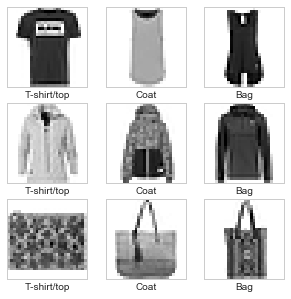

----------


In [31]:
X_train, y_train, X_test, y_test, n_classes, data_dim = generate_fashion_mnist_data(flatten=False, newaxis=True)

assert X_train.shape == (60000, 28, 28, 1)
assert X_test.shape == (10000, 28, 28, 1)

assert y_train.shape == (60000, 10)
assert y_test.shape == (10000, 10)

We can see from the summary that this is a perfectly balanced training set

### Answer 4.2

I am using `LeNet-5` instead of `MiniGoogLeNet`. Train using `Fashion MNIST data`, opt out from using `Batch Normalization` and `Dropout`.

In [32]:
def shuffle(X, y, seed=82):
    np.random.seed(seed)
    
    idxes = np.arange(X.shape[0])
    new_idxes = np.random.shuffle(idxes)
    
    return X[new_idxes][0], y[new_idxes][0]

s_X_train, s_y_train = shuffle(X_train, y_train)

In [17]:
# Doesn't use batch norm
batch_norm_params = {
    'input_layer': False,
    'conv_layers': False,
    'hidden_layers' : False,
    'prev_to_act': True
}

# Doesn't use Dropout as well
dropout_params = {
    'input_layer': False,
    'conv_layers': False,
    'hidden_layers' : False,
    'prev_to_act': True,
    'input_layer_rate': 0.2,
    'conv_layers_rate': 0.5,
    'hidden_layers_rate': 0.5
}

# Assign both batch_norm_params and dropout_params
params = {
    'batch_size': 64,
    'nb_epoch': 5,
    'verbose': 1,
    'batch_norm_params': batch_norm_params,
    'dropout_params': dropout_params
}

losses = []

for power in np.arange(-9, 2, 1):
    params['learning_rate'] = np.power(10.0, power)
    e
    model, history = train_le_net_5(s_X_train[0:10000], s_y_train[0:10000], params)
    losses.append(history.history['loss'])
    
    print('----------')
    print('Done for learning rate: 10^{}'.format(power))
    print('----------')
    print('----------')

losses = np.array(losses)

Epoch 1/5
157/157 [==============================] - 12s 74ms/step - loss: 2.2733 - accuracy: 0.1033
Epoch 2/5
157/157 [==============================] - 15s 93ms/step - loss: 2.2733 - accuracy: 0.1033
Epoch 3/5
157/157 [==============================] - 14s 88ms/step - loss: 2.2733 - accuracy: 0.1033
Epoch 4/5
157/157 [==============================] - 15s 95ms/step - loss: 2.2733 - accuracy: 0.1033
Epoch 5/5
157/157 [==============================] - 14s 90ms/step - loss: 2.2733 - accuracy: 0.1033
----------
Done for learning rate: 10^-9
----------
----------
Epoch 1/5
157/157 [==============================] - 14s 90ms/step - loss: 2.3118 - accuracy: 0.0961
Epoch 2/5
157/157 [==============================] - 15s 94ms/step - loss: 2.3118 - accuracy: 0.0961
Epoch 3/5
157/157 [==============================] - 14s 91ms/step - loss: 2.3118 - accuracy: 0.0961
Epoch 4/5
157/157 [==============================] - 16s 100ms/step - loss: 2.3118 - accuracy: 0.0961
Epoch 5/5
157/157 [========

Plot the loss from last epoch for each learning rate

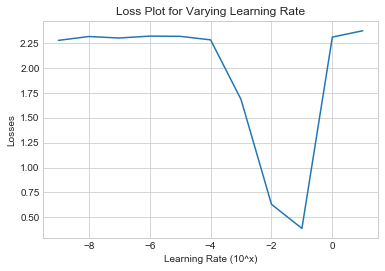

In [20]:
fig = plt.figure()
ax = plt.axes()

ax.set_title('Loss Plot for Varying Learning Rate')
ax.set_xlabel('Learning Rate (10^x)')
ax.set_ylabel('Loss')

last_losses = losses[:, params['nb_epoch']-1]

ax.plot(np.arange(-9, 2, 1), last_losses)

From the plot above, we can see that an appropriate $lr_{min}$ would be $10^{-4}$ because that's when the loss starts decreasing. Meanwhile, for $lr_{max}$, $10^{-1}$ is appropriate because that's when the loss starts increasing. Store it to the two variables below.

In [21]:
lr_min = 1e-4
lr_max = 1e-1

### Answer 4.3

In [33]:
from tensorflow.keras.callbacks import LearningRateScheduler

Create a `scheduler` which basically will produces `learning_rate` per iteration with this pattern: 
$$[10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 10^{-2}, 10^{-3}, 10^{-4}, ...]$$

In [36]:
# Note: Epoch starts from 1
def scheduler(epoch, lr):
    if epoch % 4 == 1:
        return lr_min
    elif epoch % 4 == 2:
        return lr_min * math.pow(10, 1)
    elif epoch % 4 == 3:
        return lr_min * math.pow(10, 2)
    else:
        return lr_max

# Create a callback that employs the scheduler
callback = LearningRateScheduler(scheduler)

# Attach it to params
params['callback'] = callback

# Attach test data as well
params['validation_data'] = X_test, y_test

model, history = train_le_net_5(X_train, y_train, params)

Epoch 1/5
938/938 [==============================] - 426s 454ms/step - loss: 0.9076 - accuracy: 0.6811 - val_loss: 0.8838 - val_accuracy: 0.7160
Epoch 2/5
938/938 [==============================] - 424s 452ms/step - loss: 0.5482 - accuracy: 0.8010 - val_loss: 0.5496 - val_accuracy: 0.7978
Epoch 3/5
938/938 [==============================] - 399s 425ms/step - loss: 0.4706 - accuracy: 0.8315 - val_loss: 0.4564 - val_accuracy: 0.8376
Epoch 4/5
938/938 [==============================] - 395s 421ms/step - loss: 0.4244 - accuracy: 0.8479 - val_loss: 0.4615 - val_accuracy: 0.8265
Epoch 5/5
938/938 [==============================] - 398s 424ms/step - loss: 0.3937 - accuracy: 0.8609 - val_loss: 0.4569 - val_accuracy: 0.8220


Training loss and validation loss

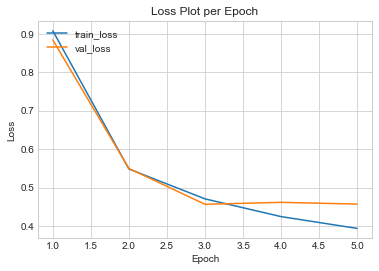

In [37]:
fig = plt.figure()
ax = plt.axes()

ax.plot(np.arange(1, 6, 1), history.history['loss'], label='train_loss')
ax.plot(np.arange(1, 6, 1), history.history['val_loss'], label='val_loss')

ax.set_title('Loss Plot per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.legend()
ax.legend(loc=2)

Training accuracy and validation accuracy

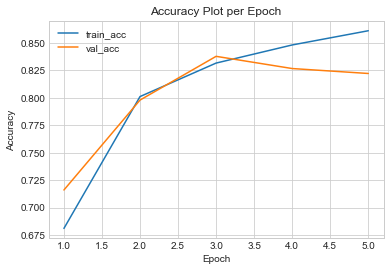

In [38]:
fig = plt.figure()
ax = plt.axes()

ax.plot(np.arange(1, 6, 1), history.history['accuracy'], label='train_acc')
ax.plot(np.arange(1, 6, 1), history.history['val_accuracy'], label='val_acc')

ax.set_title('Accuracy Plot per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

ax.legend()
ax.legend(loc=2)

### Answer 4.4

In [35]:
# Doesn't use batch norm
batch_norm_params = {
    'input_layer': False,
    'conv_layers': False,
    'hidden_layers' : False,
    'prev_to_act': True
}

# Doesn't use Dropout as well
dropout_params = {
    'input_layer': False,
    'conv_layers': False,
    'hidden_layers' : False,
    'prev_to_act': True,
    'input_layer_rate': 0.2,
    'conv_layers_rate': 0.5,
    'hidden_layers_rate': 0.5
}

# Assign both batch_norm_params and dropout_params
params = {
    'nb_epoch': 5,
    'verbose': 1,
    'learning_rate': lr_min,
    'batch_norm_params': batch_norm_params,
    'dropout_params': dropout_params
}

losses = []
batch_sizes = []

b = 64
while b < 8192:
    batch_sizes.append(b)
    b = b * 2

for batch_size in batch_sizes:    
    params['batch_size'] = batch_size
    
    model, history = train_le_net_5(X_train[0:10000], y_train[0:10000], params)
    losses.append(history.history['loss'])
    
    print('----------')
    print('Done for batch_size: {}'.format(batch_size))
    print('----------')
    print('----------')
    
losses = np.array(losses)

Epoch 1/5
157/157 [==============================] - 21s 131ms/step - loss: 2.2953 - accuracy: 0.1304
Epoch 2/5
157/157 [==============================] - 33s 207ms/step - loss: 2.2756 - accuracy: 0.1383
Epoch 3/5
157/157 [==============================] - 21s 132ms/step - loss: 2.2532 - accuracy: 0.1586
Epoch 4/5
157/157 [==============================] - 20s 128ms/step - loss: 2.2406 - accuracy: 0.1592
Epoch 5/5
157/157 [==============================] - 23s 149ms/step - loss: 2.2217 - accuracy: 0.1731
----------
Done for batch_size: 64
----------
----------
Epoch 1/5
79/79 [==============================] - 20s 251ms/step - loss: 2.3104 - accuracy: 0.1088
Epoch 2/5
79/79 [==============================] - 22s 279ms/step - loss: 2.2948 - accuracy: 0.1177
Epoch 3/5
79/79 [==============================] - 22s 281ms/step - loss: 2.2833 - accuracy: 0.1253
Epoch 4/5
79/79 [==============================] - 22s 274ms/step - loss: 2.2733 - accuracy: 0.1321
Epoch 5/5
79/79 [================

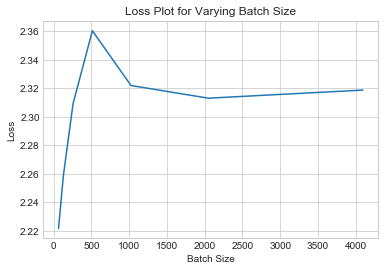

In [42]:
fig = plt.figure()
ax = plt.axes()

ax.set_title('Loss Plot for Varying Batch Size')
ax.set_xlabel('Batch Size')
ax.set_ylabel('Loss')

last_losses = losses[:, params['nb_epoch']-1]

ax.plot(batch_sizes[0:7], last_losses)

NO, the behavior is the OPPOSITE. With increasing `batch_size`, the `training loss` also tends to increase except at the region $500-2000$. Meanwhile, with increasing `learning_rate`, the `training loss` tends to decrease instead, except after reaching the region `learning_rate` $> 0.1$.

### Answer 4.5

From the plot above, we can see that an appropriate $b_{min}$ would be $512$ because that's when the loss starts decreasing. Meanwhile, for $b_{max}$, $2048$ is appropriate because that's when the loss starts increasing. Store it to the two variables below.

In [43]:
b_min = 512
b_max = 2048

My proposed algorithm is as the block diagram below:

![Batch Finder](img/Batch Finder.png)

### Answer 4.6

An analogous trajectory for `batch_size` would be `exponential increase` as we have discussed previously in Part 4.5 that the behavior is the opposite. 

In [58]:
lr_min = 1e-4
b_min = 512
b_max = 2048

# Doesn't use batch norm
batch_norm_params = {
    'input_layer': False,
    'conv_layers': False,
    'hidden_layers' : False,
    'prev_to_act': True
}

# Doesn't use Dropout as well
dropout_params = {
    'input_layer': False,
    'conv_layers': False,
    'hidden_layers' : False,
    'prev_to_act': True,
    'input_layer_rate': 0.2,
    'conv_layers_rate': 0.5,
    'hidden_layers_rate': 0.5
}

# Assign both batch_norm_params and dropout_params
params = {
    'nb_epoch': 5,
    'verbose': 0,
    'learning_rate': lr_min,
    'batch_norm_params': batch_norm_params,
    'dropout_params': dropout_params,
    'train_on_batch': True
}

idx = 0
curr_b = b_min
count_increase = 0
direction = 2

histories = []
elapsed_epoch =0
 
while elapsed_epoch < params['nb_epoch']:
    b_X_train = s_X_train[idx:idx + curr_b]
    b_y_train = s_y_train[idx:idx + curr_b]
    
    params['batch_size'] = curr_b
    
    model, history = train_le_net_5(b_X_train, b_y_train, params) 
    histories.append(history)
    
    idx = idx + curr_b
    if idx > 10000:
        elapsed_epoch += 1
        print('{} epochs done'.format(elapsed_epoch))
        
        idx = 0
        curr_b = b_min
        count_increase = 0
        direction = 2
    
    if (curr_b == b_min and direction == 1/2) or (curr_b == b_max and direction == 2):
        direction = 1 / direction
    
    # Increase geometrically after 2 batches
    count_increase = (count_increase + 1) % 2
    
    if count_increase == 0:
        curr_b = curr_b * direction

In [57]:
print(evaluate_le_net_5(model, X_test, y_test, params))

0.10010000318288803


### Answer 4.7

The cyclical LEARNING RATE policy is better because it has an EXTREMELY BETTER test accuracy ($0.822$ vs $0.1$). It seems that my cyclical learning rate policy is very poor and it is only as good as random prediction.